In [2]:
import sys
sys.path.append("..")
from utils import append_derivatives_to_dataframe
from estimators.frequency import EIVSin
import numpy as np
from scipy.integrate import odeint, solve_ivp
from simulation.excitation_signals import sinusoidal_fun,  sweep_fun
import time
import matplotlib.pyplot as plt
from collections import Counter
import math
import pandas as pd

In [51]:
config = { "K": [[4300, 430],
          [430, 4300]],
    "C": [[40, 5],
          [5, 40]],
    "t" : 2,
    "f" : 4,
    "dt" : 0.0001}


In [52]:
class SimpleSystem:
    metadata = {'render.modes': ['human']}

    def __init__(self):
        """
        Define basic variables and constants

        - gravity
        - mass (of the axis)
        - inertia : moment of inertia
        - radius: tha radius of the axis at point A and B
        - bearing constant: the constant of the magnetic bearing (Fm = bearing_constant*i^2/d^2)
        - L : the distance between the center of mass of the axis and the magnetic bearing action point
        - dt : the time between iterations

        """

        self.reset_count = 1
        self.gravity = 9.80665
        self.gravity = 0
        self.mass = 1  # axis mass

        self.dt = 0.000001
        self.q = np.array([[0],
                           [0]])
        self.q_dot = np.array([[0],
                           [0]])
        
        self.M = np.array([[1, 0],
                           [0, 1]])
        self.K = np.array([[0, 0],
                           [0, 0]])
        self.C = np.array([[0, 0],
                           [0, 0]])

    def solve(self, dt, t, force_fun):
        
        """
        
        
        Returns de solution
        
        """
        t_eval = np.arange(0, t, step=dt)
        y = np.concatenate([self.q.flatten(), self.q_dot.flatten()], axis=0).flatten()
        sol = solve_ivp(fun=self.dynamics_fn, t_span=[0, t], y0=y, method='RK45',
                        args=(force_fun,), t_eval=t_eval)

        
        
        if sol['success']:
            
            f = np.array(list(map(force_fun, sol["t"])))
            y = sol["y"]
        
            return {
                "t" : sol["t"],
                "x" : y[0, :],
                "y" : y[1, :],
                "fx" : f[:, 0],
                "fy" : f[:, 1]
            }
            
        else:
            raise ValueError('Solver error')


    def dynamics_fn(self, t, y, f):
        """

        :param t: time
        :param y:  array of shape (12,) with position and velocity
        :param f:  force
        :param mass: mass
        :param gravity: gravity
        :param Icm:
        :return:
        """
        q, q_dot = y[:2], y[2:]

        

        
        q = q.reshape((-1, 1))
        q_dot = q_dot.reshape((-1, 1))


        bearing_force = self.K @ q + self.C @ q_dot

        q_dot2 =  np.linalg.inv(self.M) @ ( - bearing_force + f(t).reshape((2, 1)) )
        
        dydt = np.concatenate([q_dot.flatten(), q_dot2.flatten()], axis=0)

        return dydt

In [62]:


def get_data(config, axis="x"):
    
    dt = config["dt"]
    t  = config["t"]
    f = config["f"]

    env = SimpleSystem()
    env.K = config["K"]
    env.C = config["C"]

    _force_fun = sinusoidal_fun(f, axis=axis)
    #_force_fun = sweep_fun(T=1, f1=4, f2=49, axis=axis)
    def force_fun(t):
    #    t = t % 1
        return 10*_force_fun(t)[:2]
    print(dt)
    res = env.solve(dt=dt, t=t, force_fun=force_fun)
    return pd.DataFrame(res)

df_x = get_data(config, axis="x")
df_x["episode"] = 0
df_y = get_data(config, axis="y")
df_y["episode"] = 0

0.0001
0.0001


In [63]:
df_x

,t,x,y,fx,fy,episode
0,0.0000,0.000000e+00,0.000000e+00,0.000000,0.0,0
1,0.0001,4.184595e-11,-5.236593e-15,0.025133,0.0,0
2,0.0002,3.343813e-10,-8.485956e-14,0.050265,0.0,0
3,0.0003,1.127424e-09,-4.275431e-13,0.075398,0.0,0
4,0.0004,2.669822e-09,-1.346490e-12,0.100529,0.0,0
...,...,...,...,...,...,...
19995,1.9995,-7.357788e-04,8.161687e-05,-0.125660,-0.0,0
19996,1.9996,-7.293361e-04,8.085422e-05,-0.100529,-0.0,0
19997,1.9997,-7.228887e-04,8.009105e-05,-0.075398,-0.0,0
19998,1.9998,-7.164368e-04,7.932737e-05,-0.050265,-0.0,0


In [64]:
df_x = append_derivatives_to_dataframe(df_x, "x", dt=config["dt"])
df_x = append_derivatives_to_dataframe(df_x, "y", dt=config["dt"])
df_y = append_derivatives_to_dataframe(df_y, "x", dt=config["dt"])
df_y = append_derivatives_to_dataframe(df_y, "y", dt=config["dt"])

In [65]:
df = pd.concat([df_x, df_y])
X = df[["x_dot", "y_dot", "x", "y"]].values
df["fx_"] = df["fx"] - 1*df["x_dot2"]
df["fy_"] = df["fy"] - 1*df["y_dot2"]
Y = df[["fx_", "fy_"]].values
params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
params

array([[  40.0139799 ,    5.00308672],
       [   5.00308672,   40.0139799 ],
       [4300.14448065,  430.03667779],
       [ 430.03667779, 4300.14448065]])

In [66]:
df = pd.concat([df_x, df_y])
X = df[["x_dot2", "y_dot2", "x_dot", "y_dot", "x", "y"]].values

Y = df[["fx", "fy"]].values
params = np.linalg.inv( X.transpose() @ X ) @ X.transpose() @ Y
params

array([[ 9.97672685e-01, -8.12681747e-04],
       [-8.12681747e-04,  9.97672685e-01],
       [ 4.00151516e+01,  5.00349705e+00],
       [ 5.00349705e+00,  4.00151516e+01],
       [ 4.29866616e+03,  4.29522117e+02],
       [ 4.29522117e+02,  4.29866616e+03]])

In [67]:
estimator = EIVSin()
estimator.estimate(df_x=df_x,
                   df_y=df_y,
                   freq=config["f"])

Freq 4.0000000000004405 , length (1,)


{'freq': 4.0000000000004405,
 'G': array([[3671.33018855+1020.57626257j,  430.44715669 +124.38370083j],
        [ 430.44715669 +124.38370083j, 3671.33018855+1020.57626257j]]),
 'C': array([[40.60743925,  4.94907021],
        [ 4.94907021, 40.60743925]]),
 'K': array([[4302.98487022,  430.44715669],
        [ 430.44715669, 4302.98487022]])}

In [68]:
estimator = EIVSin()
df_xf = estimator.get_frequency_domain_data(df_x, freq=config["f"], dt=config["dt"])
df_yf = estimator.get_frequency_domain_data(df_y, freq=config["f"], dt=config["dt"])

In [69]:
df = pd.concat([df_xf, df_yf], ignore_index=False)


def get_frequency_of_interest(df, freq):
    # Apenas frequencia de interesse
    sel_df = df[(df["freqs"] > freq - 1e-1) & (df["freqs"] < freq + 1e-1)].sort_index()
    # Apenas indices que exisitam no dataframe x e y
    inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(df.index).most_common()))))
    
    return sel_df



get_frequency_of_interest(df, config["f"])

,xf,yf,fyf,fxf,freqs
10008,-7.119859-25.640657j,0.806500+3.023277j,0.000000+0.000000j,0.000000-100000.000000j,4.0
10008,0.806500+3.023277j,-7.119859-25.640657j,0.000000-100000.000000j,0.000000+0.000000j,4.0


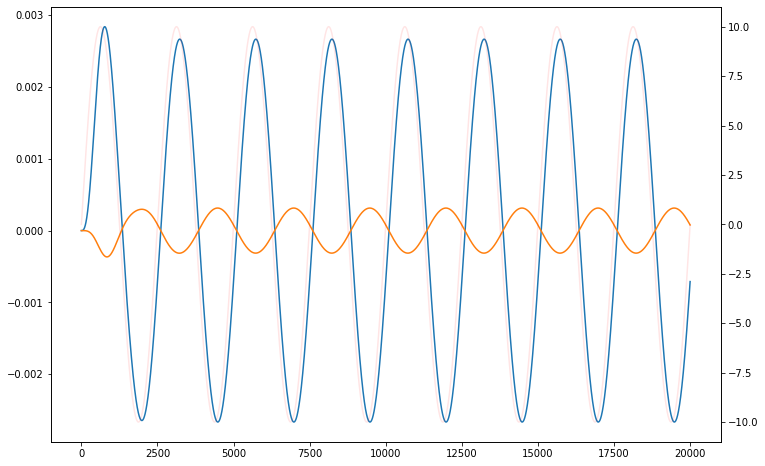

In [70]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax2.plot(df_x["fx"], color="red", alpha=0.1)
ax1.plot(df_x["x"])
ax1.plot(df_x["y"])

fig.show()
#plt.xlim((.4, 1))
#plt.ylim(-1e-3, 1e-3)

In [49]:
f = np.array(list(map(force_fun, t)))

NameError: name 'force_fun' is not defined

NameError: name 't' is not defined

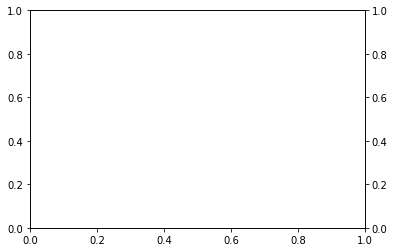

In [50]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t, y[:, 0])
ax2.plot(t, f[:, 0], color="red", alpha=0.1)
fig.show()
#plt.xlim((.4, 1))
#plt.ylim(-1e-3, 1e-3)

In [175]:
np.mean(f[:, 0])

-4.3655745685100557e-16

In [43]:
np.arange(0, 2, 0.5)

array([0. , 0.5, 1. , 1.5])